# SiraSafe

## Include Dependency

In [1]:
#import

import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import glob
from keras.utils import to_categorical

from keras.layers import *
from keras.models import Model
from keras.models import Sequential
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16

from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import model_from_json

import math


import random



from sklearn.model_selection import train_test_split
from sklearn.model_selection  import KFold
from sklearn.metrics import log_loss

import h5py


## Data Exploratory

/var/folders/_t/s9_kytcd1lqbv1tyz6v8l8pr0000gn/T/ipykernel_6920/967549063.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_list['class_type'] = img_list['classname'].str.extract('(\d)',expand=False).astype(np.float)


<Figure size 640x480 with 0 Axes>

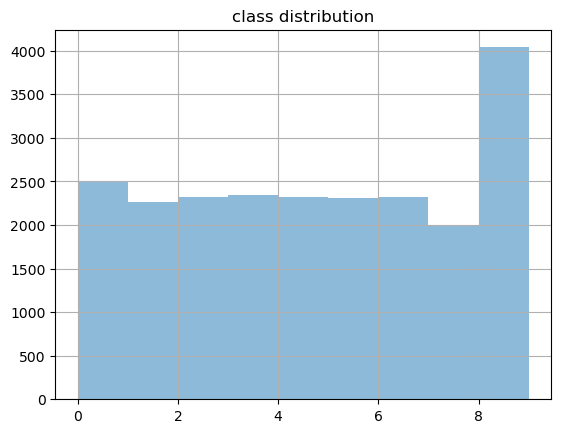

In [2]:
img_list = pd.read_csv('capserver/data/driver_imgs_list.csv')
img_list['class_type'] = img_list['classname'].str.extract('(\d)',expand=False).astype(np.float)
plt.figure()
img_list.hist('class_type',alpha=0.5,layout=(1,1),bins=9)
plt.title('class distribution')
plt.draw()
plt.show()

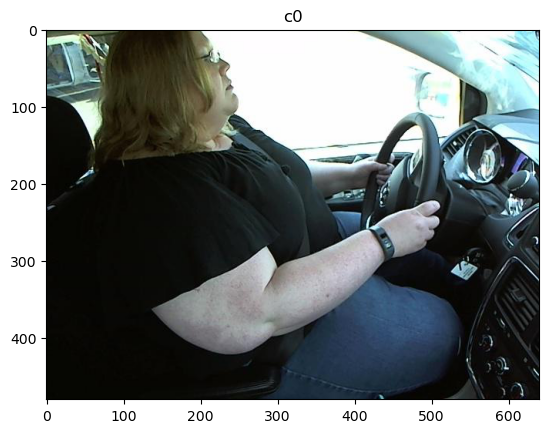

In [3]:
path = os.path.join('capserver/data/train/c0/img_104.jpg')
import matplotlib.image as mpimg
img=mpimg.imread(path)
#resized = cv2.resize(img, (100, 80), cv2.INTER_LINEAR)
plt.title('c0')
plt.imshow(img)
plt.show()

## Data Preprocessing

When we import the dataset, we need to resize the orignal image first, here is the example:

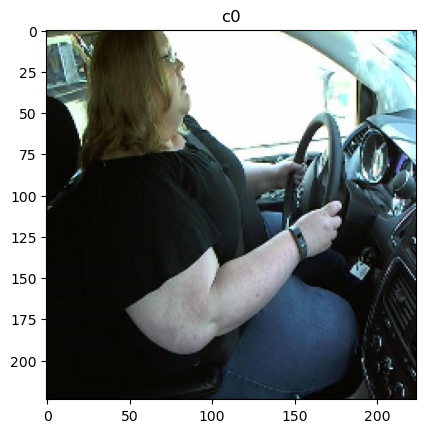

In [4]:
resized = cv2.resize(img, (224, 224), cv2.INTER_LINEAR)
plt.title('c0')
plt.imshow(resized)
plt.show()

We want all image to be substracted by the mean value, the example is shown below:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


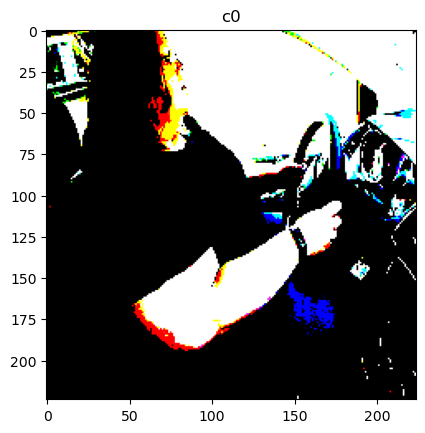

In [5]:
resized = resized.astype('float32')
mean = [103.939,116.779,123.68]
resized[:, :, 0] -= mean[0]   
resized[:, :, 1] -= mean[1]
resized[:, :, 2] -= mean[2]
plt.title('c0')
plt.imshow(resized)
plt.show()

## Create training input

Load the data and resize to create training set.

In [6]:
X_train = []
y_train = []

for i in range(10):    
    path = os.path.join( 'capserver/data/train/c' + str(i), '*.jpg')
    files = glob.glob(path)
    for fl in files:
        img = cv2.imread(fl)
        img = cv2.resize(img, (224, 224), cv2.INTER_LINEAR)
        X_train.append(img)
        y_train.append(i)

In [7]:
X_train = np.array(X_train, dtype=np.uint8)
y_train = np.array(y_train, dtype=np.uint8)

In [8]:
from keras import utils
X_train = X_train.astype('float16')
y_train = utils.to_categorical(y_train, 10)

In [9]:
mean = [103.939,116.779,123.68]
X_train[:, :, :, 0] -= mean[0]   
X_train[:, :, :, 1] -= mean[1]
X_train[:, :, :, 2] -= mean[2]

print('the shape of training set: ', X_train.shape)

the shape of training set:  (22424, 224, 224, 3)


## Training Model Design

In [10]:
# Load pre-trained ResNet50 model
model_resnet50_conv = ResNet50(weights='imagenet', include_top=False)
model_resnet50_conv.summary()

# Define input layer with a different name
input_layer = Input(shape=(224, 224, 3), name='image_input')

output_resnet50_conv = model_resnet50_conv(input_layer)

x = Flatten()(output_resnet50_conv)
x = Dense(10, activation='softmax', name='predictions')(x)

model = Model(inputs=input_layer, outputs=x)  # Use 'inputs' instead of 'input'
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, None, None, 64)       16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, None, None, 64)       256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, None, None, 64)       0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, None, None, 512)      66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, None, None, 512)      2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, None, None, 512)      0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, None, None, 256)      590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, None, None, 256)      1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, None, None, 256)      0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, None, None, 1024)     525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, None, None, 1024)     0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, None, None, 256)      262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, None, None, 256)      1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, None, None, 1024)     4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, None, None, 1024)     0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, None, None, 1024)     0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, None, None, 512)      0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, None, None, 512)      2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, None, None, 512)      2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, None, None, 512)      0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [11]:
#VGG16
def train_model_1():
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)

    # Create your own input format (here 3x200x200)
    image_input = Input(shape=(120, 100, 3), name='image_input')

    # Use the generated model 
    output_vgg16_conv = model_vgg16_conv(image_input)

    # Add the fully-connected layers 
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dense(10, activation='softmax', name='predictions')(x)

    # Create your own model 
    model = Model(inputs=image_input, outputs=x)

    # In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
    # model.summary()
    model.compile(Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
 

In [12]:
def train_model_3():
    model_xception_conv = Xception(weights='imagenet', include_top=False)
    
    input_layer = Input(shape=(224, 224, 3), name='image_input')
    
    output_xception_conv = model_xception_conv(input_layer)
    x = Flatten()(output_xception_conv)
    
    x = Dense(10, activation='softmax', name='predictions')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    
    model.compile(Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [13]:
def train_model_4():
    model_InceptionV3_conv = InceptionV3(weights='imagenet', include_top=False)

    input_layer = Input(shape=(224, 224, 3), name='image_input')

    output_InceptionV3_conv = model_InceptionV3_conv(input_layer)
    x = Flatten()(output_InceptionV3_conv)

    x = Dense(10, activation='softmax', name='predictions')(x)

    model = Model(inputs=input_layer, outputs=x)

    model.compile(Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [14]:
def train_model_5():
    model_vgg19_conv = VGG19(weights='imagenet', include_top=False)
    
    image_input = Input(shape=(224, 224, 3), name='image_input')
  
    output_vgg19_conv = model_vgg19_conv(image_input)

    x = Flatten(name='flatten')(output_vgg19_conv)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.2)(x)
    x = Dense(10, activation='softmax', name='predictions')(x)
    
    model = Model(inputs=image_input, outputs=x)
    
    model.compile(Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
def train_model():
    model_resnet50_conv = ResNet50(weights='imagenet', include_top=False)

    input_layer = Input(shape=(224, 224, 3), name='image_input')

    output_resnet50_conv = model_resnet50_conv(input_layer)

    x = Flatten()(output_resnet50_conv)
    #x = Dropout(0.3)(x)
    x = Dense(10, activation='softmax', name='predictions')(x)

    model = Model(inputs=input_layer, outputs=x)

    model.compile(Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## Model Visualization

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


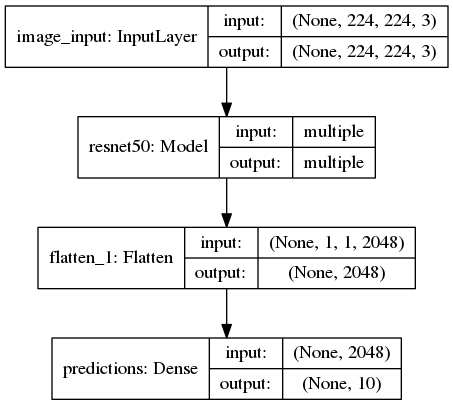

In [16]:
from keras.utils import plot_model
from IPython.display import Image, SVG
model=train_model()
plot_model(model,show_shapes=True)
Image(filename = 'model.png')

## Train Model and Save

In [ ]:
foldn = 0
n_splits = 5
log_list = []
np.random.seed(2016)

# Replace n_folds with n_splits here
kf = KFold(n_splits=n_splits, shuffle=True, random_state=51)

for train, test in kf.split(X_train):
    model = train_model()
    foldn += 1
    
    print('number {} fold of {} folds cross validation'.format(foldn,n_splits))
    print('Split into training and validation set', len(X_train[train]), len(X_train[test]))
        
    weights_path = os.path.join('cache', 'weights_' + str(foldn) + '.h5')
    
    callbacks = [                
                EarlyStopping(monitor='val_loss', patience=10, verbose=0),
                ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True, verbose=1, mode='auto'),                
                ]
    log = model.fit(X_train[train], y_train[train], batch_size=32, epochs=40,
                    shuffle=True, verbose=1, validation_data=(X_train[test], y_train[test]),
                    callbacks=callbacks)
          
    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('model loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test', 'val_train', 'val_test'], loc='upper right')
    plt.show()
    
    plt.plot(log.history['accuracy'])  # 'accuracy' instead of 'acc'
    plt.plot(log.history['val_accuracy'])  # 'val_accuracy' instead of 'val_acc'
    plt.title('model accuracy')  # 'accuracy' instead of 'acc'
    plt.ylabel('model accuracy')  # 'accuracy' instead of 'acc'
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()


number 1 fold of 5 folds cross validation
Split into training and validation set 17939 4485


In [ ]:
# 6folds for 3 models: Xception, InceptionV3, Resnet50 
"""
foldn=0
n_folds=6
log_list=[]
np.random.seed(2017)
kf = KFold(X_train.shape[0], n_folds=n_folds, shuffle=True,random_state=51)

for train, test in kf:
            
    foldn += 1
    if foldn == 1:
        model = train_model_3()
    elif foldn == 2:
        model = train_model_4()
    elif foldn == 3:
        model = train_model_3()
    elif foldn == 4:
        model = train_model_4()
    elif foldn == 5:
        model = train_model_2()
    else:
        model = train_model_2()
        
    print('number {} fold of {} folds cross validation'.format(foldn, n_folds))
    print('Split into training and validation set', len(X_train[train]), len(X_train[test]))   
        
    weights_path = os.path.join('cache', 'weights_' + str(foldn) + '.h5')
    
    callbacks = [                
                EarlyStopping(monitor='val_loss', patience=12, verbose=0),
                ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True, verbose=1, mode='auto'),                
                ]
    log=model.fit(X_train[train], y_train[train], batch_size=32, epochs=40,
                  shuffle=True, verbose=1, validation_data=(X_train[test],y_train[test]),
                  callbacks=callbacks)
          
    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('model loss')
    plt.xlabel('epoch')
    plt.legend(['train','test','val_train','val_test'], loc='upper right')
    plt.show()
    
    plt.plot(log.history['acc'])
    plt.plot(log.history['val_acc'])
    plt.title('model acc')
    plt.ylabel('model acc')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper right')
    plt.show()
    
"""

## Save Model

In [ ]:
with open('model.json', 'w') as f:
    f.write(model.to_json())

## Create Submission

In [ ]:
batch_size = 32
fold_n = 0
y_test_all = []
nfolds=5

In [ ]:
for i in range(nfolds):    
    fold_n += 1
    print('calculate the number {} fold result:'.format(fold_n))
    model = train_model()
    weights_path = os.path.join('cache', 'weights_' + str(fold_n) + '.h5')
    model.load_weights(weights_path)
    
    test_prediction = []
    for part in range(5):
        print('Reading part {} of test data'.format(part))
        
        path = os.path.join('..','capserver','data', 'imgs', 'test', '*.jpg')
        files = sorted(glob.glob(path))
        
        #split_list     
        length = len(files)    
        split_list = [files[i*length // 5: (i+1)*length // 5] for i in range(5)]

        X_test = []  
        for fl in split_list[part]:            
            img=cv2.imread(fl)
            img=cv2.resize(img,(224,224), cv2.INTER_LINEAR)
            X_test.append(img)
           
            
        X_test = np.array(X_test,dtype=np.uint8)
        X_test = X_test.astype('float16')
        
        mean=[103.939, 116.779, 123.68]
        X_test[:,:,:,0]-=mean[0]
        X_test[:,:,:,1]-=mean[1]
        X_test[:,:,:,2]-=mean[2]
        
        print('number of test data part {} : {}'.format(part, X_test.shape[0]))
        print('start predict:')
        test_prediction_part = model.predict(X_test, batch_size=batch_size, verbose=1)
        test_prediction_part = test_prediction_part.clip(min=0.005,max=1)
        for p in test_prediction_part:
             test_prediction.append(p)
    
    y_test_all.append(test_prediction)

calculate the number 1 fold result:


/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`
  if sys.path[0] == '':


Reading part 0 of test data
number of test data part 0 : 15945
start predict:
15945/15945 [==============================] - 200s   
Reading part 1 of test data
number of test data part 1 : 15945
start predict:
15945/15945 [==============================] - 195s   
Reading part 2 of test data
number of test data part 2 : 15945
start predict:
15945/15945 [==============================] - 195s   
Reading part 3 of test data
number of test data part 3 : 15945
start predict:
15945/15945 [==============================] - 195s   
Reading part 4 of test data
number of test data part 4 : 15946
start predict:
15946/15946 [==============================] - 195s   
calculate the number 2 fold result:
Reading part 0 of test data
number of test data part 0 : 15945
start predict:
15945/15945 [==============================] - 200s   
Reading part 1 of test data
number of test data part 1 : 15945
start predict:
15945/15945 [==============================] - 195s   
Reading part 2 of test data
numbe

In [ ]:
#merge
Y_test_mer=np.array(y_test_all[0])
for i in range(1, 5):
    Y_test_mer+=np.array(y_test_all[i])
Y_test_mer/=5
Y_test_mer=Y_test_mer.tolist()


In [ ]:
len(Y_test_mer)

79726

In [ ]:
len(y_test_all[0])

79726

In [ ]:
X_id=[]
path = os.path.join('..','capserver','data', 'imgs', 'test', '*.jpg')
files = sorted(glob.glob(path))
for f in files:
    image_name = os.path.basename(f)
    X_id.append(image_name)

In [ ]:
len(X_id)

79726

In [ ]:
#submit

result = pd.DataFrame(Y_test_mer, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
result.loc[:,'img'] = pd.Series(X_id, index=result.index)
creat_file = os.path.join('subm', 'submission'+'.csv')
result.to_csv(creat_file, index=False)

#single model submit
for i in range(5):
    result = pd.DataFrame(y_test_all[i], columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result.loc[:,'img'] = pd.Series(X_id, index=result.index)
    creat_file = os.path.join('subm', 'submission_'+str(i)+'.csv')
    print(creat_file)
    result.to_csv(creat_file, index=False)

subm/submission_0.csv
subm/submission_1.csv
subm/submission_2.csv
subm/submission_3.csv
subm/submission_4.csv


# Sample Prediction

In [ ]:
def predict(path):

    X_test = []
    X_test_id = []


    #fl = os.path.basename(path)
    img = cv2.imread(path)
    # Reduce size
    resized = cv2.resize(img, (224, 224), cv2.INTER_LINEAR)

    X_test.append(resized)
    
    
    test_data = np.array(X_test, dtype=np.uint8)
    test_data = test_data.astype('float16')   
    mean_pixel = [103.939, 116.779, 123.68]
    print('Substract mean')
    test_data[:, :, :, 0] -= mean_pixel[0]   
    test_data[:, :, :, 1] -= mean_pixel[1]
    test_data[:, :, :, 2] -= mean_pixel[2]
    model=train_model()
    weights_path = os.path.join('cache', 'weights_' + str(5) + '.h5')
    model.load_weights(weights_path)

    test_prediction = model.predict(test_data,verbose=1)
    result=str(np.argmax(test_prediction))
    return img,result


In [ ]:
path1 = os.path.join('..','capserver','data', 'imgs', 'test', 'img_1.jpg')
img,result=predict(path1)

Substract mean


/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`


1/1 [==============================] - 3s


In [ ]:
result

'5'

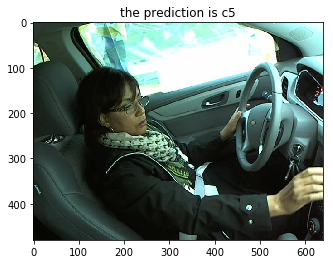

In [ ]:
plt.title('the prediction is c'+result)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

Substract mean


/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`


1/1 [==============================] - 3s


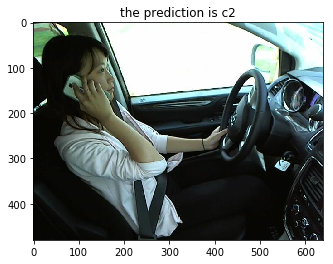

In [ ]:
path2 = os.path.join('..','capserver','data', 'imgs', 'test', 'img_2.jpg')
img,result=predict(path2)
plt.title('the prediction is c'+result)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()